<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module2/Project/ImageRetrieval/ImageRetrievalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This project aims to solve Image Retrieval**

In [ ]:
!pip install chromadb
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import chromadb

#Load data

In [ ]:
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF

Downloading...
From (original): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
From (redirected): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF&confirm=t&uuid=4eb4f224-9704-48e3-9697-4eb0ad9adb99
To: /content/data.zip
100% 76.1M/76.1M [00:02<00:00, 30.7MB/s]


In [ ]:
!unzip -q data.zip

In [ ]:
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

In [ ]:
def read_image_from_path(path, size):
  img = Image.open(path).convert('RGB').resize(size)
  img = np.array(img)
  return img

def folder_to_images(folder, size):
  list_dir = [folder + '/' + name for name in os.listdir(folder)]
  images_np = np.zeros(shape=(len(list_dir), *size, 3))
  images_path = []
  for i, path in enumerate(list_dir):
    images_np[i] = read_image_from_path(path, size)
    images_path.append(path)
  return images_np, images_path

In [ ]:
def plot_results(query_path, ls_path_score, reverse=False):
  query = read_image_from_path(query_path, size)
  sorted_path_score = sorted(ls_path_score, key=lambda x: x[1], reverse=reverse)
  plt_shape = (2,3)

  fig, axes = plt.subplots(plt_shape[0], plt_shape[1], figsize=(6, 3))

  query_name = os.path.basename(os.path.dirname(query_path))
  axes[0, 0].imshow(query)
  axes[0, 0].axis('off')
  axes[0, 0].text(0.5, -0.1, f"Query: {query_name}", size=10, ha="center", transform=axes[0, 0].transAxes)

  for i, (path, score) in enumerate(sorted_path_score):
      if (i >= plt_shape[0] * plt_shape[1] - 1):
        break
      row = (i + 1) // plt_shape[1]
      col = (i + 1) % plt_shape[1]
      img = read_image_from_path(path, size)
      image_name = os.path.basename(os.path.dirname(path))
      axes[row, col].imshow(img)
      axes[row, col].axis('off')
      axes[row, col].text(0.5, -0.1, f"Top {i+1}: {image_name}", size=10, ha="center", transform=axes[row, col].transAxes)

  plt.tight_layout()
  plt.show()


#Using simple metrics

##Using L1 score

In [ ]:
def absolute_difference(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  return np.sum(np.abs(query - data), axis=axis_batch_size)

In [ ]:
def get_l1_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + '/' + folder
      images_np, images_path = folder_to_images(path, size)
      rates = absolute_difference(query, images_np)
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

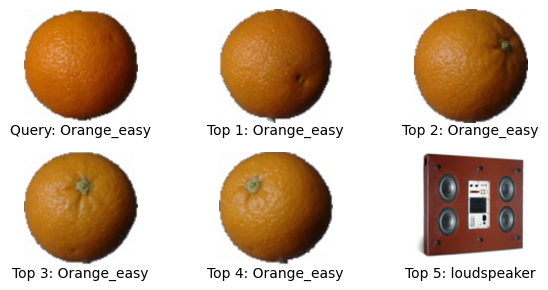

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

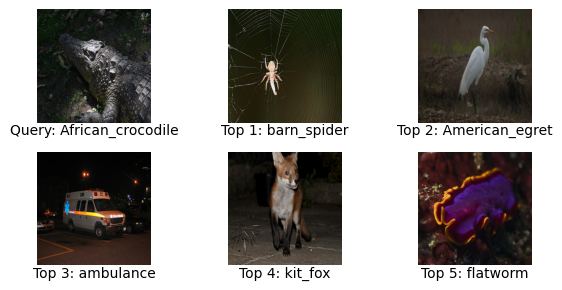

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

##Using L2 score

In [ ]:
def mean_square_difference(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  return np.sum(np.square(query - data), axis=axis_batch_size)

In [ ]:
def get_l2_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + '/' + folder
      images_np, images_path = folder_to_images(path, size)
      rates = mean_square_difference(query, images_np)
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

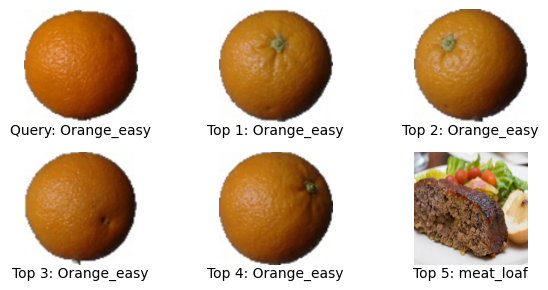

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

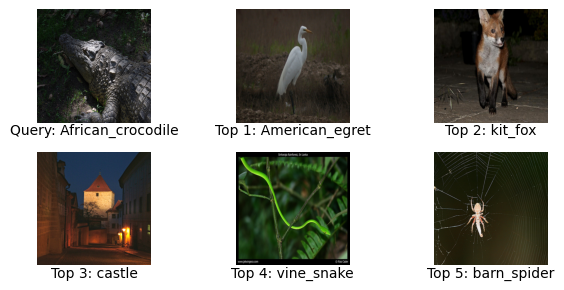

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

##Using cosine similarity

In [ ]:
def cosine_similarity(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  query_norm = np.sqrt(np.sum(query**2))
  data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))
  return np.sum(query * data, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

In [ ]:
def get_cosine_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + '/' + folder
      images_np, images_path = folder_to_images(path, size)
      rates = cosine_similarity(query, images_np)
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

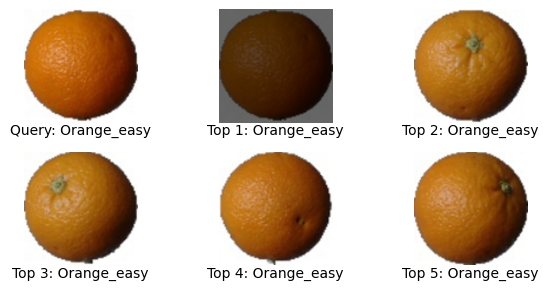

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_cosine_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

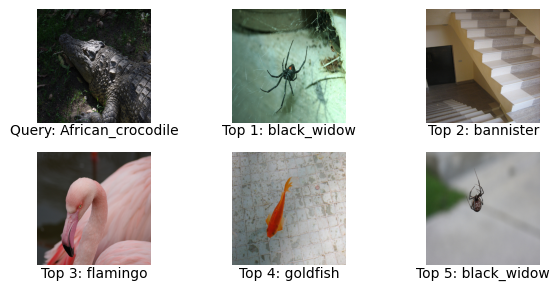

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_cosine_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

##Using Correlation Coefficient

In [ ]:
def correlation_coefficient(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  query_mean = query - np.mean(query)
  data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)
  query_norm = np.sqrt(np.sum(query_mean**2))
  data_norm = np.sqrt(np.sum(data_mean**2, axis=axis_batch_size))
  return np.sum(query_mean * data_mean, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

In [ ]:
def get_correlation_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + '/' + folder
      images_np, images_path = folder_to_images(path, size)
      rates = correlation_coefficient(query, images_np)
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

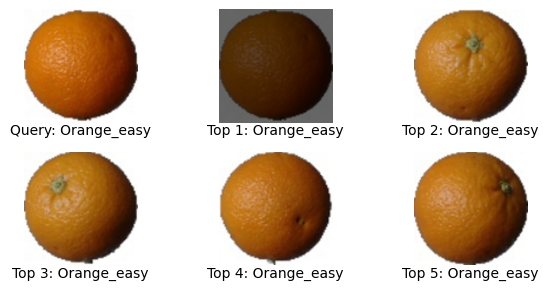

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_correlation_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

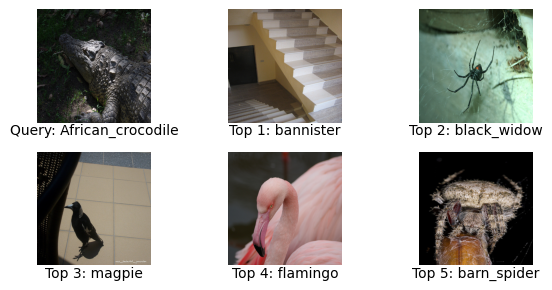

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_correlation_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

#Upgrade using pretrained deep learning model

**We will increase the accuracy by using pre-trained deep learning model from Clip. I will take L1 and L2 score as examples**

In [ ]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
  embedding = embedding_function._encode_image(image=image)
  return np.array(embedding)

##Upgrade L1 socre

In [ ]:
def get_l1_score_clip(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  query_embedding = get_single_image_embedding(query)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + '/' + folder
      images_np, images_path = folder_to_images(path, size)

      embedding_list = []
      for idx_img in range(images_np.shape[0]):
        embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
        embedding_list.append(embedding)

      rates = absolute_difference(query_embedding, np.array(embedding_list))
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

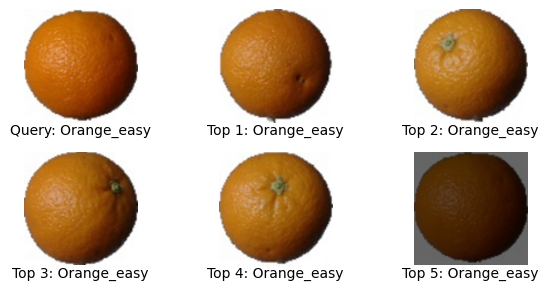

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l1_score_clip(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

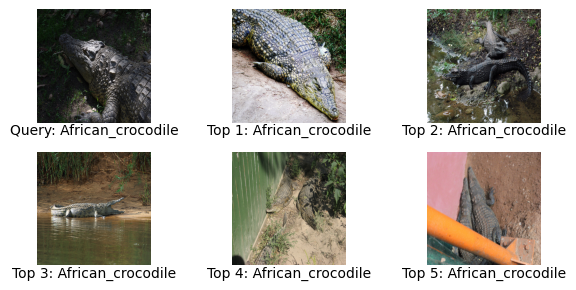

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_l1_score_clip(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

##Upgrade L2 score

In [ ]:
def get_l2_score_clip(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  query_embedding = get_single_image_embedding(query)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + '/' + folder
      images_np, images_path = folder_to_images(path, size)

      embedding_list = []
      for idx_img in range(images_np.shape[0]):
        embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
        embedding_list.append(embedding)

      rates = mean_square_difference(query_embedding, np.array(embedding_list))
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

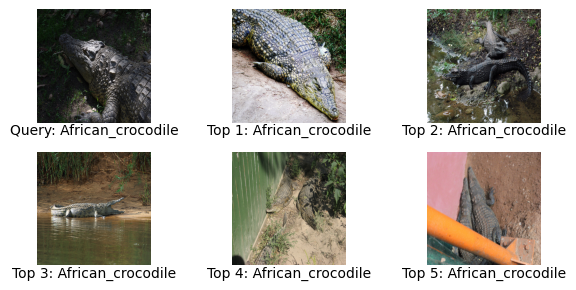

In [ ]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_l2_score_clip(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

#Optimize the process

**We continue to improve the performance by using a vector database to manage the embedding**

##Preprocess

In [ ]:
def get_files_path(path):
  files_path = []
  for label in CLASS_NAME:
    label_path = path + '/' + label
    filenames = os.listdir(label_path)
    for filename in filenames:
      files_path.append(label_path + '/' + filename)
  return files_path

data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)

In [ ]:
def plot_results(image_path, files_path, results):
  query = read_image_from_path(image_path, size)

  plt_shape = (2, 3)  # Shape of the plot grid
  fig, axes = plt.subplots(plt_shape[0], plt_shape[1], figsize=(6, 3))

  # Display query image
  query_name = os.path.basename(os.path.dirname(image_path))
  axes[0, 0].imshow(query)
  axes[0, 0].axis('off')
  axes[0, 0].text(0.5, -0.1, f"Query: {query_name}", size=10, ha="center", transform=axes[0, 0].transAxes)

  # Display retrieved images
  for i in range(len(results['distances'][0])):
      retrieved_id = results['ids'][0][i]
      # Extract the numerical part of the ID using split
      index = int(retrieved_id.split('_')[1])
      file_path = files_path[index]  # Assuming ID format is 'id_index'
      img = read_image_from_path(file_path, size)
      image_name = os.path.basename(os.path.dirname(file_path))

      row = (i + 1) // plt_shape[1]
      col = (i + 1) % plt_shape[1]
      axes[row, col].imshow(img)
      axes[row, col].axis('off')
      axes[row, col].text(0.5, -0.1, f"Top {i + 1}: {image_name}", size=10, ha="center", transform=axes[row, col].transAxes)

  plt.tight_layout()
  plt.show()

In [ ]:
def add_embedding(collection, files_path):
  ids = []
  embeddings = []
  for id, path in enumerate(files_path):
    ids.append(f'id_{id}')
    image = Image.open(path).convert('RGB')
    # Convert the image to a NumPy array
    image_np = np.array(image)
    embedding = get_single_image_embedding(image = image_np)
    embeddings.append(embedding)
  collection.add(embeddings = embeddings, ids = ids)

In [ ]:
chroma_client = chromadb.Client()
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection", metadata={"hnsw:space": "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

In [ ]:
def search(image_path, collection, n_results):
  query_image = read_image_from_path(image_path, size)
  query_embedding = get_single_image_embedding(query_image)
  results = collection.query(query_embeddings=query_embedding, n_results=n_results)
  return results

##Optimized Consine similarity

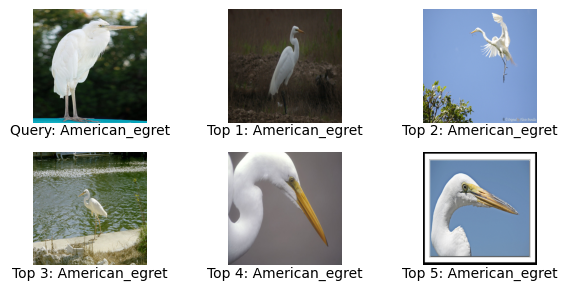

In [ ]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)

#Get images from flickr.com

This part will demonstrate how to collect image data from flickr.com

##Crawl URL from website

In [ ]:
!pip install tqdm

!apt-get update
!apt-get install -y wget
!pip install selenium
!apt-get install -y chromium-browser
!apt-get install -y chromium-chromedriver

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,283 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,622 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup # For parsing HTML content
from urllib.parse import urljoin, urlparse # For handling URLs
import urllib.request # For making HTTP requests
import time # For handling time-related operations
import os # For interacting with the operating system (relate to dir, folder, file)
from tqdm import tqdm # For displaying progress bars (visualize progress)
import concurrent.futures # For multi-threading
import json # For writing to a text file
from PIL import Image # For handling images

import concurrent.futures
from tqdm import tqdm
import json
import threading

In [ ]:
class UrlScraper:
  # Constructor
  def __init__(self, url_template, max_images=50, max_workers=4):
    self.url_template = url_template # Link crawl
    self.max_images = max_images # Max images
    self.max_workers = max_workers # Thread
    self.setup_environment() # Call for set up environment

  # Set up environment for selenium
  def setup_environment(self):
    os.environ['PATH'] += ':/usr/lib/chromium-browser/'
    os.environ['PATH'] += ':/usr/lib/chromium-browser/chromedriver/'

  def get_url_images(self, term, pbar, lock):
    """
    Crawl the urls of images by term

    Parameters:
    term (str): The name of animal, plant, scenery, furniture

    Returns:
    urls (list): List of urls of images
    """

    #Initialize Chrome driver
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)

    url = self.url_template.format(search_term=term)
    driver.get(url)

    urls = []
    more_content_available = True

    while len(urls) < self.max_images and more_content_available:
        soup = BeautifulSoup(driver.page_source, "html.parser")
        img_tags = soup.find_all("img")

        for img in img_tags:
            if len(urls) >= self.max_images:
                break

            if 'src' in img.attrs:
                href = img.attrs['src']
                img_path = urljoin(self.url_template, href)
                #Resize the image to big
                img_path = img_path.replace("_m.jpg", "_b.jpg").replace("_n.jpg", "_b.jpg").replace("_w.jpg", "_b.jpg")

                #Skip the logo
                if img_path == "https://combo.staticflickr.com/ap/build/images/getty/IStock_corporate_logo.svg":
                    continue

                urls.append(img_path)
                with lock:
                    pbar.update(1)
                    pbar.refresh()

        try:
            #Click the load more button
            load_more_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "Load More")]'))
            )
            load_more_button.click()
            time.sleep(2)
        except:
            #If there is no load more button, scroll
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)

            new_soup = BeautifulSoup(driver.page_source, "html.parser")
            new_img_tags = new_soup.find_all("img", loading="lazy")

            if len(new_img_tags) == len(img_tags):  # Stop if no new images are loaded
                more_content_available = False

            img_tags = new_img_tags

    pbar.close()
    driver.quit()
    return urls

  def scrape_urls(self, categories):
      """
      Main function to scrape image URLs for multiple categories in parallel.
      Uses a single shared tqdm progress bar across all threads.
      """
      all_urls = {category: {} for category in categories}
      total_tasks = sum(len(terms) for terms in categories.values())
      lock = threading.Lock()
      with tqdm(total=self.max_images * total_tasks, desc="Fetching Images", position=0, leave=True) as pbar:
          with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
              future_to_term = {executor.submit(self.get_url_images, term, pbar, lock): (category, term)
                                for category, terms in categories.items() for term in terms}

              for future in concurrent.futures.as_completed(future_to_term):
                  category, term = future_to_term[future]

                  try:
                      urls = future.result()
                      all_urls[category][term] = urls
                      tqdm.write(f"{category} - {term}: {len(urls)} images retrieved")
                  except Exception as exc:
                      tqdm.write(f"{category} - {term} generated an exception: {exc}")

      return all_urls

  def save_to_file(self, data, filename):
    with open(filename, 'w') as file:
      json.dump(data, file, indent=4)
    print(f"Data saved to {filename}")

In [ ]:
categories = {
    "animal": ["Monkey", "Elephant", "cows", "Cat", "Dog", "bear", "fox", "Civet", "Pangolins",
               "Rabbit", "Bats", "Whale", "Cock", "Owl", "flamingo", "Lizard", "Turtle", "Snake",
               "Frog", "Fish", "shrimp", "Crab", "Snail", "Coral", "Jellyfish", "Butterfly", "Flies",
               "Mosquito", "Ants", "Cockroaches", "Spider", "scorpion", "tiger", "bird", "horse",
               "pig", "Alligator", "Alpaca", "Anteater", "donkey", "Bee", "Buffalo", "Camel",
               "Caterpillar", "Cheetah", "Chicken", "Dragonfly", "Duck", "panda", "Giraffe"],

    "plant": ["Bamboo", "Apple", "Apricot", "Banana", "Bean", "Wildflower", "Flower",
              "Mushroom", "Weed", "Fern", "Reed", "Shrub", "Moss", "Grass", "Palmtree", "Corn",
              "Tulip", "Rose", "Clove", "Dogwood", "Durian", "Ferns", "Fig", "Flax", "Frangipani",
              "Lantana", "Hibiscus", "Bougainvillea", "Pea", "OrchidTree", "RangoonCreeper",
              "Jackfruit", "Cottonplant", "Cornelinatree", "Coffeeplant", "Coconut", "wheat",
              "watermelon", "radish", "carrot"],

    "furniture": ["bed", "cabinet", "chair", "chests", "clock", "desks", "table", "Piano",
                  "Bookcase", "Umbrella", "Clothes", "cart", "sofa", "ball", "spoon", "Bowl",
                  "fridge", "pan", "book"],

    "scenery": ["Cliff", "Bay", "Coast", "Mountains", "Forests", "Waterbodies", "Lake",
                "desert", "farmland", "river", "hedges", "Plain", "sky", "cave", "cloud",
                "flowergarden", "glacier", "grassland", "horizon", "lighthouse", "plateau",
                "savannah", "valley", "volcano", "waterfall"]
}

urltopic = {"flickr": "https://www.flickr.com/search/?text={search_term}"}

scraper = UrlScraper(url_template=urltopic["flickr"], max_images=20, max_workers=5)
image_urls = scraper.scrape_urls(categories)
scraper.save_to_file(image_urls, 'image_urls.json')


Fetching Images:   4%|▎         | 100/2680 [01:04<27:35,  1.56it/s]


animal - Dog: 20 images retrieved
animal - Monkey: 20 images retrieved
animal - cows: 20 images retrieved
animal - Elephant: 20 images retrieved
animal - Cat: 20 images retrieved
animal - bear: 20 images retrieved
animal - Pangolins: 20 images retrieved
animal - fox: 20 images retrieved
animal - Civet: 20 images retrieved
animal - Rabbit: 20 images retrieved
animal - Bats: 20 images retrieved
animal - Owl: 20 images retrieved
animal - Whale: 20 images retrieved
animal - flamingo: 20 images retrieved
animal - Cock: 20 images retrieved
animal - Lizard: 20 images retrieved
animal - Frog: 20 images retrieved
animal - Turtle: 20 images retrieved
animal - Snake: 20 images retrieved
animal - Fish: 20 images retrieved
animal - Crab: 20 images retrieved
animal - Snail: 20 images retrieved
animal - shrimp: 20 images retrieved
animal - Coral: 20 images retrieved
animal - Jellyfish: 20 images retrieved
animal - Butterfly: 20 images retrieved
animal - Flies: 20 images retrieved
animal - Cockroaches

##Crawl images from url

In [ ]:
class ImageDownloader:
  def __init__(self, json_file, download_dir='Dataset', max_workers=4, delay=1):
    self.json_file = json_file # file containing URLs of images in JSON format
    self.download_dir = download_dir # Folder name for storing images
    self.max_workers = max_workers # Number of threads
    self.delay = delay # Polite delay: when we send request too much to the server for
                      #downloading images without polite delay, it will crash or prevent your IP
    self.filename = set() # To store filename directories
    self.setup_directory() # Set up the folder structure

  def setup_directory(self):
    if not os.path.exists(self.download_dir):
      os.makedirs(self.download_dir)

  def read_json(self):
    '''
    Read the JSON file and return the data.

    Returns:
    data (dict): The data from the JSON file.
    '''
    with open(self.json_file, 'r') as file:
      data = json.load(file)
    return data

  def is_valid_url(self, url):
    '''
    Check if the URL is valid.

    Parameters:
    url (str): The URL to check.

    Returns:
    bool: True if the URL is valid, False otherwise.
    '''
    try:
      with urllib.request.urlopen(url) as response:
        if response.status == 200 and 'image' in response.info().get_content_type():
          return True
    except Exception:
      return False

  def download_image(self, url, category, term, pbar):
    '''
    Download an image from the given URL.

    Parameters:
    url (str): The URL of the image to download
    category (str): The category of the image
    term (str): The term associated with the image
    pbar (tqdm): The progress bar for displaying download progress

    Returns:
    None
    '''
    if not self.is_valid_url(url):
      pbar.update(1)
      return f"Invalid URL: {url}"

    category_dir = os.path.join(self.download_dir, category)
    if not os.path.exists(category_dir):
      os.makedirs(category_dir)

    term_dir = os.path.join(category_dir, term)
    if not os.path.exists(term_dir):
      os.makedirs(term_dir)

    filename = os.path.join(term_dir, os.path.basename(urlparse(url).path))
    self.filename.add(filename)

    try:
      urllib.request.urlretrieve(url, filename)
      pbar.update(1)
      return f"Downloaded: {filename}"
    except Exception as e:
      pbar.update(1)
      return f"Error downloading {url}: {e}"

  def download_images(self):
    '''
    Download images from the URLs in the JSON file.

    Returns:
    None
    '''
    data = self.read_json()
    download_tasks = []

    total_images = sum(len(urls) for terms in data.values() for urls in terms.values())
    with tqdm(total=total_images, desc="Downloading images") as pbar:
      with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
        for category, terms in data.items():
          for term, urls in terms.items():
            for url in urls:
              download_tasks.append(executor.submit(self.download_image, url, category, term, pbar))
              time.sleep(self.delay) # Polite delay

        for future in concurrent.futures.as_completed(download_tasks):
          print(future.result())

    self.export_filename()

  def export_filename(self):
    '''
    Export the filenames of downloaded images to a text file.

    Returns:
    None
    '''
    with open('filename.txt', 'w') as file:
      for filename in sorted(self.filename):
        file.write(f"{filename}\n")



In [ ]:
downloader = ImageDownloader(json_file='image_urls.json', download_dir='Dataset', max_workers=4, delay=1)
downloader.download_images()


Downloaded: Dataset/plant/Apple/95703586_bd2ef4700e_b.jpg
Downloaded: Dataset/animal/Giraffe/32302947415_fa6eb3aa32_b.jpg
Downloaded: Dataset/animal/Coral/3913138516_049506b130_b.jpg
Downloaded: Dataset/animal/Lizard/37656380036_7f099d87f4_b.jpg
Downloaded: Dataset/scenery/Mountains/33634268778_2ceca3a531_b.jpg
Downloaded: Dataset/plant/Wildflower/48637191942_52f3ee5e7f_b.jpg
Downloaded: Dataset/animal/pig/2470950790_09e9cf9637_b.jpg
Downloaded: Dataset/scenery/Waterbodies/50357169191_0ee6267402_b.jpg
Downloaded: Dataset/plant/watermelon/52189470994_7d7aa5081e_b.jpg
Downloaded: Dataset/animal/tiger/379238475_be293dcb91_b.jpg
Downloaded: Dataset/scenery/Waterbodies/47303333742_96292f8cea_b.jpg
Downloaded: Dataset/plant/Flower/5643059213_0d2011e9e2_b.jpg
Downloaded: Dataset/animal/scorpion/6595524039_f9e9c34077_b.jpg
Downloaded: Dataset/furniture/book/6043817389_bd29c3035a_b.jpg
Downloaded: Dataset/plant/Apricot/9300205950_7c041a6550_b.jpg
Downloaded: Dataset/animal/Giraffe/8269195775_a0

Downloaded: Dataset/scenery/farmland/5374872023_377b7e6147_b.jpg
Downloaded: Dataset/plant/Bean/4300636744_3dcb938a25_b.jpg
Downloaded: Dataset/animal/Dog/1411975591_29c0b25189_b.jpg
Downloaded: Dataset/scenery/river/33536478982_3d81789b9a_b.jpg
Downloaded: Dataset/furniture/book/37399955870_20de29c4f3_b.jpg
Downloaded: Dataset/plant/Flax/52165451234_360fc2c6ce_b.jpg
Downloaded: Dataset/plant/Apple/2259087838_8b4c7c249c_b.jpg
Downloaded: Dataset/animal/shrimp/233169073_da697f9b1b_b.jpg
Downloaded: Dataset/scenery/valley/41944674610_f3a549e37b_b.jpg
Downloaded: Dataset/furniture/sofa/270081182_92483ed242_b.jpg
Downloaded: Dataset/scenery/flowergarden/52907535941_bb752d30ef_b.jpg
Downloaded: Dataset/plant/Fig/16346019857_8c8e320ea0_b.jpg
Downloaded: Dataset/plant/Dogwood/51174618507_92b824442a_b.jpg
Downloaded: Dataset/animal/Turtle/4520876420_cf1b4f06c9_b.jpg
Downloaded: Dataset/scenery/savannah/6933887101_71f444b8dc_b.jpg
Downloaded: Dataset/scenery/Waterbodies/18330576478_f275fb2dfd_b